In [1]:
import black
import jupyter_black

jupyter_black.load(
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY314,
)

DEBUG:jupyter_black:Using config from /home/andersle/src/chemometrics_solutions/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY314: 14>}}


# Exercise set 5: PCA, clustering, and outliers in least squares

The main goals of this exercise are to use PCA

**Learning Objectives:**

After completing this exercise set, you will be able to:

- Use PCA to find interesting variables.
- Find outliers in connection with least squares.
- Run agglomerative clustering and interpret a dendrogram.

**To get the exercise approved, complete the following problems:**

* [5.2(b)](#5.2(b)) and [5.2(c)](#5.2(c)): To show that you find outliers in connection with least squares.
* [5.3(a)](#5.3(a)) and [5.3(b)](#5.3(b)): To show that you can run agglomerative clustering, make a dendrogram and interpret it.

**Files required for this exercise:**
* [Exercise 5.1](#Exercise-5.1): [ovo.csv](ovo.csv)
* [Exercise 5.2](#Exercise-5.2): [forbes.csv](forbes.csv)
* [Exercise 5.3](#Exercise-5.3): [zoo.csv](zoo.csv)

Please ensure that these files are saved in the same directory as this notebook.

## Exercise 5.1
[Schummer *et al.*](https://doi.org/10.1016/S0378-1119(99)00342-X) used microarray technology to analyse the expression of 1536 genes in ovarian cancer and non-cancer tissues. Their primary objective was to identify differentially expressed genes in ovarian cancer versus non-cancer tissues to discover genes with diagnostic potential.

The data file [`ovo.csv`](ovo.csv) contains numerical gene expressions (for 1536 genes) for 54 tissue samples. Each column corresponds to a specific gene, named `X.1`, `X.2`, and so on. Each tissue sample has been classified as non-cancer (`N`) or cancer (`C`) tissue, and these labels can be found in the column `class`. The raw data has been preprocessed by centring each gene expression so that no further preprocessing is needed. The raw data can be loaded as follows:

In [2]:
# Load the data set
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_theme(style="ticks", context="notebook", palette="colorblind")

data_ovo = pd.read_csv("ovo.csv")
classes = data_ovo["class"]  # Classification of samples.
X_ovo = data_ovo.filter(like="X.", axis=1)  # Gene expressions for samples.

### 5.1(a)

**Task: Explore the raw data. Do you find genes that appear to show significant differences in expression between non-cancer and cancer tissue?**

**Hint:** You can, for instance, explore the data by running a principal component analysis. If you want to avoid making the PCA plots from scratch, try the [yellowbrick library](https://www.scikit-yb.org/en/latest/api/features/pca.html) to visualise the scores and loadings.

In [3]:
# Your code here

#### Your answer to question 5.1(a): Did you find any promising genes?
*Double click here*

## Exercise 5.2
[Forbes](https://doi.org/10.1017/S0080456800032075) investigated the
relationship between the boiling point of water and the atmospheric pressure, and collected data in the Alps and Scotland. Forbes' goal was to estimate altitudes from the boiling point alone.

We will use Forbes' data to make a linear model for predicting the atmospheric pressure, and we will investigate if there are any outliers.

### 5.2(a)

**Task: Create a linear model that predicts the atmospheric pressure
from the boiling point
with `statsmodels`. Plot your model together with the raw data, and plot the residuals. Do you have
any comments about the residuals?**

In [4]:
# Here is some code to get you started:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

%matplotlib inline
sns.set_context("notebook")

In [5]:
# If the code above fails because you do not have statsmodels installed,
# you can uncomment and run this:
#!pip install statsmodels

In [6]:
# The raw data can be loaded with:
data_forbes = pd.read_csv("forbes.csv")
data_forbes.head()

,Temperature (F),Pressure (inches Hg)
0,194.5,20.79
1,194.3,20.79
2,197.9,22.40
3,198.4,22.67
4,199.4,23.15


In [7]:
# To create the least squares model with statsmodels:
x = data_forbes["Temperature (F)"]
y = data_forbes["Pressure (inches Hg)"]

X = sm.add_constant(x)  # Make a matrix with a column of ones and then x.

model = sm.OLS(y, X)  # Set up for OLS = Ordinary Least Squares.
results = model.fit()  # Find parameters.
y_hat = results.predict(X)  # Use the model to predict y_hat.

# Print a small summary to show R² and the coefficients:
print(results.summary(slim=True))

                             OLS Regression Results                             
Dep. Variable:     Pressure (inches Hg)   R-squared:                       0.994
Model:                              OLS   Adj. R-squared:                  0.994
No. Observations:                    17   F-statistic:                     2677.
Covariance Type:              nonrobust   Prob (F-statistic):           2.53e-18
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -81.0637      2.052    -39.508      0.000     -85.437     -76.690
Temperature (F)     0.5229      0.010     51.741      0.000       0.501       0.544

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


**Note:** A description of the summary from statsmodels can be found in the [Appendix](#Appendix:-The-summary-results-from-statsmodels).

In [8]:
# Your code here

#### Your answer to question 5.2(a): Do you have any comments about the residuals?
*Double click here*

### 5.2(b)

**Task: Obtain different outlier measures and plot them. Do you see any potential outliers?**

**Hint**: Calculate [influence/outlier measures with statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.html#statsmodels.stats.outliers_influence.OLSInfluence) and plot the following:

* (i) the studentised residuals,
* (ii) the leverage ($h_{ii}$ from the $\mathbf{H}$-matrix),
* (iii) the Cook's distance, and
* (iv) the [influence plot](https://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.influence_plot.html).

You can find example code for doing this below.

In [9]:
# The influence measures can be computed with:
influence = results.get_influence()

# The measures can be converted to a pandas data frame with:
influence_table = influence.summary_frame()

# And they can be accessed as follows:
# (i) studentised residuals:
studentised_residuals = influence_table["student_resid"]

# (ii) the leverage:
hii = influence_table["hat_diag"]

# (iii) Cook's distance
cooks_distance = influence_table["cooks_d"]

In [10]:
# Create your plots (i)-(iii) here:

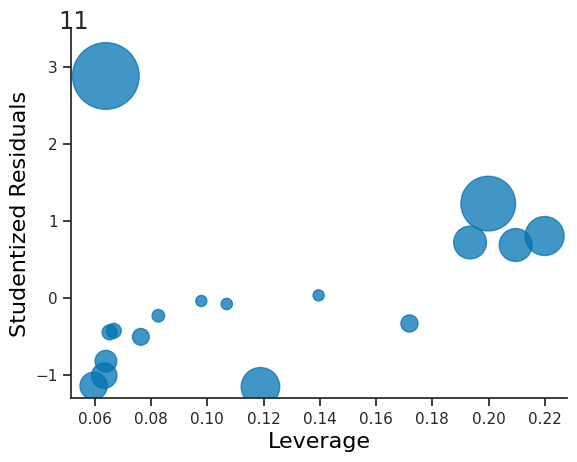

In [11]:
# The influence plot, part (iv) can be created with:
fig = influence.plot_influence()
ax = fig.get_axes()[0]
ax.set_ylim(-1.3, 3.5)
ax.set_title("")
sns.despine(fig=fig)

#### Your answer to question 5.2(b): Do you see any potential outliers?
*Double click here*

### 5.2(c)

**Task: Run a hypothesis test for outliers. Are any points marked as outliers?**

**Hint:** You use the [outlier test](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.outlier_test.html)
method from `statsmodels` to run the hypothesis test (see the code in the cell below).

This test outputs:
* `student_resid`: The studentised residuals.
* `unadj_p`: The unadjusted p-value for the hypothesis test that the expected value of the studentized residual for point *i* is zero, under the null hypothesis that the point is not an outlier.
* `bonf(p)`: A Bonferroni corrected p-value, which adjusts for the increased risk of Type I errors (mistaken rejection of a true null hypothesis) due to multiple comparisons.

The `outlier_test` method tests the null hypothesis that each point is not an outlier by considering if its studentized residual is significantly different from zero. Since we perform this test *N* times for *N* points, the risk of incorrectly labelling at least one point as an outlier (Type I error) increases. To mitigate this, `outlier_test` will apply a [correction](https://en.wikipedia.org/wiki/Bonferroni_correction), and we should base our decisions on these corrected p-values.

You can identify a point as an outlier if the corrected p-value is smaller than the significance level, set to `alpha = 0.05` by default in the `outlier_test()` method.

In [12]:
# This is how you run the hypothesis test:
test = results.outlier_test()
test[test["bonf(p)"] < 0.05]

,student_resid,unadj_p,bonf(p)
11,4.178413,0.000929,0.015788


#### Your answer to question 5.2(c): Were any points identified as outliers?
*Double click here*

### 5.2(d)

**Task: You should have found one outlier in the previous problem. Remake the model without this point and
compare it with the model you made in part [5.2(a)](#5.2(a)). Did the model change substantially?**

In [13]:
# Your code here

#### Your answer to question 5.2(d): Did removing the outlier change the model substantially?
*Double click here*

## Exercise 5.3
The data file [zoo.csv](zoo.csv) contains some data on different animals:

| Column | Description |
| :---  | :--- |
| `animal name` | The name for the animal (e.g., lion, penguin). |
| `hair` | Does the animal have hair or fur? (0=no/1=yes) |
| `feathers` | Does the animal have feathers? (0=no/1=yes) |
| `eggs` | Does the animal lay eggs? (0=no/1=yes) |
| `milk` | Does the animal provide milk for its young? (0=no/1=yes) |
| `airborne` | Does the animal fly? (0=no/1=yes) |
| `aquatic` | Does the animal live in or depend on water? (0=no/1=yes) |
| `predator` | Does the animal hunt other animals? (0=no/1=yes) |
| `toothed` | Does the animal have teeth? (0=no/1=yes) |
| `backbone` | Does the animal have a spine? (0=no/1=yes) |
| `breathes` | Does it breathe air (using lungs)? (0=no/1=yes) |
| `venomous` | Does the animal produce toxins or venom? (0=no/1=yes) |
| `fins` | Does the animal have fins for swimming? (0=no/1=yes) |
| `legs` | The number of legs (normalised to the range 0 to 1). |
| `tail` | Does the animal have a tail? (0=no/1=yes) |
| `domestic` | Is it commonly domesticated by humans? (0=no/1=yes)|
| `catsize` | Is the animal larger than a housecat? (0=no/1=yes) |


We will use clustering on this data set to see if we can group animals.

### 5.3(a)

**Task: Run the code below to perform [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) for the data in [zoo.csv](zoo.csv).**


**Note:** As you may have noticed, we have many binary variables and one numerical variable (`legs`). Mixing variable types can be problematic when we are calculating a distance. We will ignore the potential issues related to this in this exercise. 

In [14]:
# Import libraries:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set_context("notebook")

In [15]:
# Read the data:
data_zoo = pd.read_csv("zoo.csv")
data_zoo.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,bear,1,0,0,1,0,0,1,1,1,1,0,0,0.50,0,0,1
1,cat,1,0,0,1,0,0,1,1,1,1,0,0,0.50,1,1,1
2,chicken,0,1,1,0,1,0,0,0,1,1,0,0,0.25,1,1,0
3,crow,0,1,1,0,1,0,1,0,1,1,0,0,0.25,1,0,0
4,dogfish,0,0,1,0,0,1,1,1,1,0,0,1,0.00,1,0,1


In [16]:
# Store some variables
animal_names = data_zoo["animal name"].values
variables = [i for i in data_zoo.columns if i not in ("animal name",)]
X_zoo = data_zoo[variables]

In [17]:
# Import the clustering class:
from sklearn.cluster import AgglomerativeClustering

In [24]:
# Define the clustering:
model0 = AgglomerativeClustering(
    n_clusters=1,
    linkage="average",
    metric="sokalmichener",
    compute_distances=True,
)


# Here:
# n_clusters: Stop the clustering when n_clusters are found. Here it is set to 1, meaning that we will stop
# when there is one cluster.
# linkage: Selects the method for computing distances between clusters. Here it is set to average, meaning that
# it calculates the average distance between the points in the clusters.
# metric: Selects how the distances are calculated. Here "sokalmichener" selects a Sokal-Michener distance that takes
# both matches and dissimilarities into account. We are not using an Euclidean distance since we have
# almost exclusively boolean variables (0/1).
# compute_distances: Set to True, meaning that distances (for visualisation in a dendrogram) are computed.

# Run the clustering:
model0.fit(X_zoo)

,"n_clusters n_clusters: int or None, default=2The number of clusters to find. It must be ``None`` if``distance_threshold`` is not ``None``.",1
,"metric metric: str or callable, default=""euclidean""Metric used to compute the linkage. Can be ""euclidean"", ""l1"", ""l2"",""manhattan"", ""cosine"", or ""precomputed"". If linkage is ""ward"", only""euclidean"" is accepted. If ""precomputed"", a distance matrix is neededas input for the fit method. If connectivity is None, linkage is""single"" and affinity is not ""precomputed"" any valid pairwise distancemetric can be assigned.For an example of agglomerative clustering with different metrics, see:ref:`sphx_glr_auto_examples_cluster_plot_agglomerative_clustering_metrics.py`... versionadded:: 1.2",'sokalmichener'
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the output of the computation of the tree.By default, no caching is done. If a string is given, it is thepath to the caching directory.",None
,"connectivity connectivity: array-like, sparse matrix, or callable, default=NoneConnectivity matrix. Defines for each sample the neighboringsamples following a given structure of the data.This can be a connectivity matrix itself or a callable that transformsthe data into a connectivity matrix, such as derived from`kneighbors_graph`. Default is ``None``, i.e, thehierarchical clustering algorithm is unstructured.For an example of connectivity matrix using:class:`~sklearn.neighbors.kneighbors_graph`, see:ref:`sphx_glr_auto_examples_cluster_plot_ward_structured_vs_unstructured.py`.",None
,"compute_full_tree compute_full_tree: 'auto' or bool, default='auto'Stop early the construction of the tree at ``n_clusters``. This isuseful to decrease computation time if the number of clusters is notsmall compared to the number of samples. This option is useful onlywhen specifying a connectivity matrix. Note also that when varying thenumber of clusters and using caching, it may be advantageous to computethe full tree. It must be ``True`` if ``distance_threshold`` is not``None``. By default `compute_full_tree` is ""auto"", which is equivalentto `True` when `distance_threshold` is not `None` or that `n_clusters`is inferior to the maximum between 100 or `0.02 * n_samples`.Otherwise, ""auto"" is equivalent to `False`.",'auto'
,"linkage linkage: {'ward', 'complete', 'average', 'single'}, default='ward'Which linkage criterion to use. The linkage criterion determines whichdistance to use between sets of observation. The algorithm will mergethe pairs of cluster that minimize this criterion.- 'ward' minimizes the variance of the clusters being merged.- 'average' uses the average of the distances of each observation of the two sets.- 'complete' or 'maximum' linkage uses the maximum distances between all observations of the two sets.- 'single' uses the minimum of the distances between all observations of the two sets... versionadded:: 0.20 Added the 'single' optionFor examples comparing different `linkage` criteria, see:ref:`sphx_glr_auto_examples_cluster_plot_linkage_comparison.py`.",'average'
,"distance_threshold distance_threshold: float, default=NoneThe linkage distance threshold at or above which clusters will not bemerged. If not ``None``, ``n_clusters`` must be ``None`` and``compute_full_tree`` must be ``True``... versionadded:: 0.21",None
,"compute_distances compute_distances: bool, default=FalseComputes distances between clusters even if `distance_threshold` is notused. This can be used to make dendrogram visualization, but introducesa computational and memory overhead... versionadded:: 0.24For an example of dendrogram visualization, see:ref:`sphx_glr_auto_examples_cluster_plot_agglomerative_dendrogram.py`.",True


**Note:** You can select different options for the `linkage` and the `metric` to see how this influences the results (the dendrogram produced in the next problem). Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) for options.

### 5.3(b)

**Task: Run the code below to create the dendrogram of the clustering performed above. Then consider the following:**
1. What animal is "human" most similar to?
2. What animal is "platypus" most similar to?
3. What animal is least similar to any of the others?

In [22]:
# To create the dendrogram, use this code:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<IPython.core.display.Javascript object>


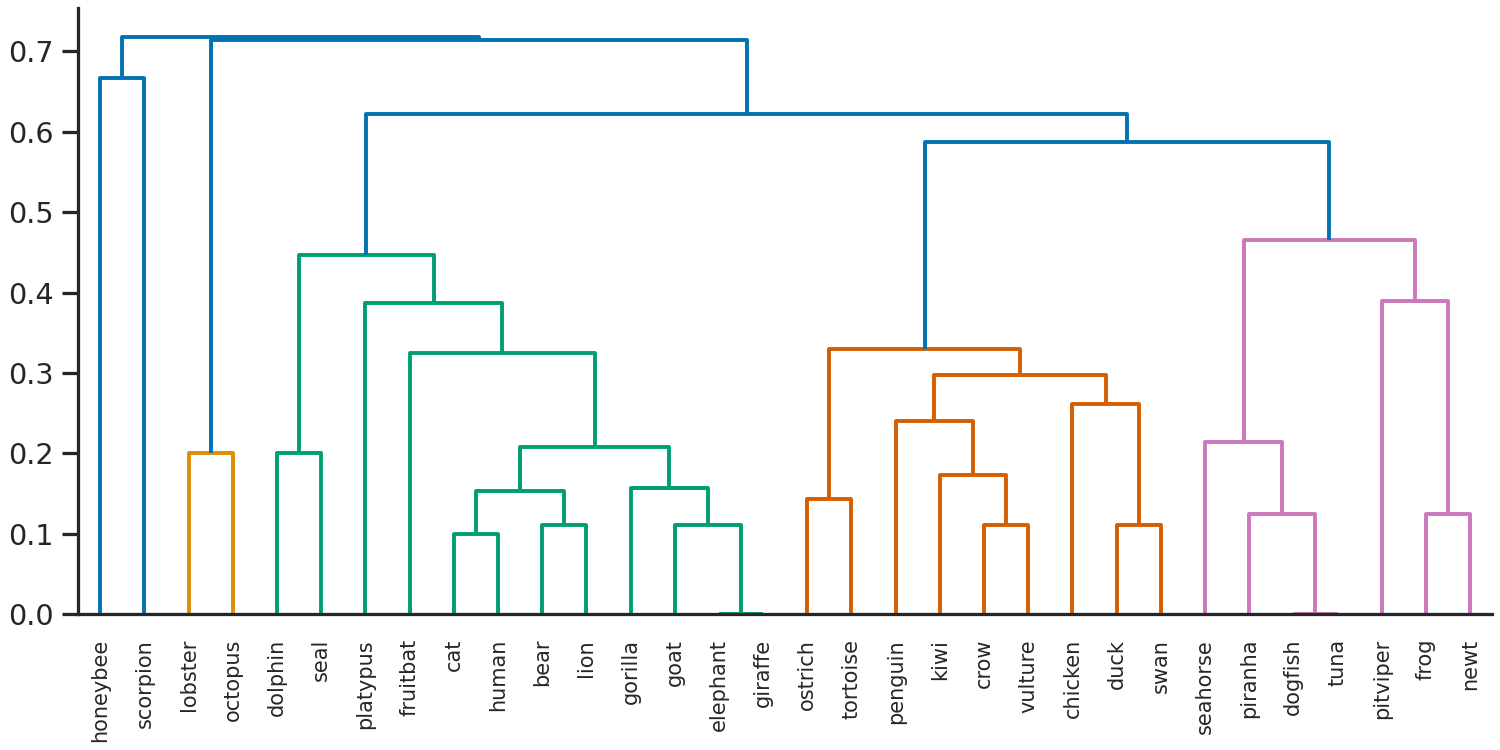

In [23]:
fig, axes = plt.subplots(constrained_layout=True, figsize=(8, 4))
plot_dendrogram(
    model0,
    truncate_mode="level",
    labels=animal_names,
    ax=axes,
    p=100,
    leaf_rotation=90,
)
sns.despine(fig=fig)

#### Your answer to question 5.3(b):

*Double click here*

1. What animal is "human" most similar to?
2. What animal is "platypus" most similar to?
3. What animal is least similar to any of the others?